# Flower_recognition

Putting my learning's on working on this data from Kaggle. The goal is to create a model which will classify the below flower images: 
* daisy  
* dandelion 
* rose 
* sunflower 
* tulip

Using a `resnet34` model, with fewer epochs. Implemented the learning_rate finder technique one of the best technique I came across so far in the Chapters. I tried out what I had learned so far in Fastai at this project. 

Kaggle link : https://www.kaggle.com/alxmamaev/flowers-recognition

In [1]:
from fastai.vision.all import * 
from fastai import * 
import pandas as pd 
import numpy as np 

In [3]:
# The path to the data 

data = Path('flowers/')

In [4]:
# Getting the file names 

fns = get_image_files(data)
fns

(#8646) [Path('flowers/flowers/tulip/4516198427_0e5099cd8e.jpg'),Path('flowers/flowers/tulip/15096307668_589504b03f_n.jpg'),Path('flowers/flowers/tulip/113902743_8f537f769b_n.jpg'),Path('flowers/flowers/tulip/7094271655_79a6f972c1_n.jpg'),Path('flowers/flowers/tulip/443600168_cb08d56511.jpg'),Path('flowers/flowers/tulip/16582481123_06e8e6b966_n.jpg'),Path('flowers/flowers/tulip/924782410_94ed7913ca_m.jpg'),Path('flowers/flowers/tulip/3991423020_9aaf2b5974_n.jpg'),Path('flowers/flowers/tulip/11746276_de3dec8201.jpg'),Path('flowers/flowers/tulip/8711277462_b43df5454b_m.jpg')...]

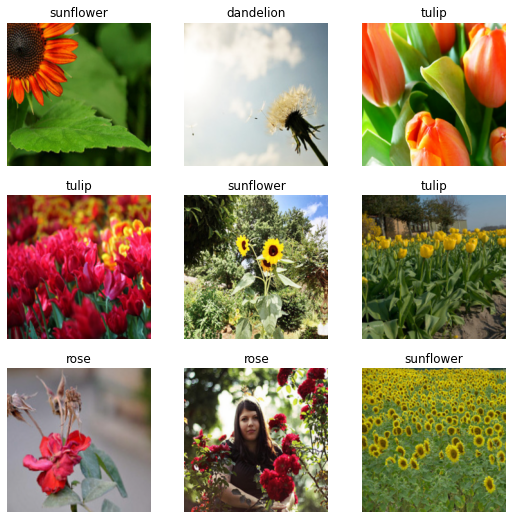

In [30]:
# Building a Data Block 

flowers = DataBlock(blocks=(ImageBlock , CategoryBlock) , 
                   get_items=get_image_files , 
                   splitter=RandomSplitter(0.2) ,
                   get_y = parent_label, 
                   item_tfms = RandomResizedCrop(460, min_scale=0.75),
                   batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

# Creating a Dataloader 

dls = flowers.dataloaders(data , bs = 64)

# Checking how well our data has been formatted 
dls.show_batch()

In [31]:
# Creating a model 

learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[error_rate , accuracy]).to_fp16()

In [32]:
# Running just for 1 epoch 

learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.641359,0.289619,0.095486,0.904514,00:59


In [33]:
# Now unfreezing all the networks 

learn.unfreeze()

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=1.5848931980144698e-06)

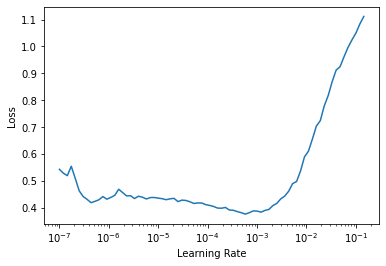

In [34]:
# Finding the learning rate 

learn.lr_find()

In [35]:
# Running our model with that lr 

learn.fit_one_cycle(5 , lr_max = slice(5e-5 , 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.311404,0.168045,0.052662,0.947338,01:22
1,0.174363,0.110179,0.031250,0.968750,01:22
2,0.093895,0.074746,0.020255,0.979745,01:22
3,0.055241,0.065008,0.020255,0.979745,01:22
4,0.032417,0.062414,0.019097,0.980903,01:21


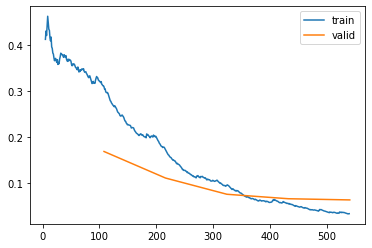

In [36]:
# Plotting validation and training loss

learn.recorder.plot_loss()

Hmm! Alright let's see where our model got confused. 

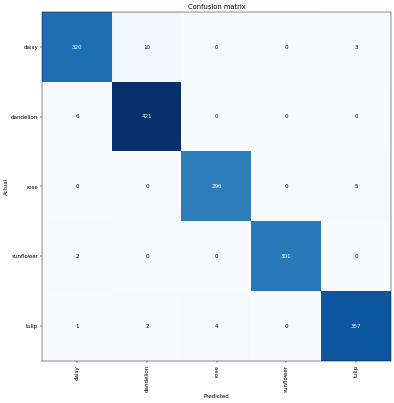

In [37]:
# Confusion Matrix 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(16,10) , dpi = 40)


Seems more confusion came between tulips and roses. Let's try to fix this by using our cleaner. 

**Note**: I actually went through all those below steps, which helped me to fix my model. I reduced my epochs and played a little bit with the learning rate even made some changes on the transforms. If you see the confusion matrix above, there were lot of mismatched images, observing them through the below steps and I decided to run my model again. 

In [23]:
# Cleaning the data 

from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
# Deleting certain images 
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()

# Replacing certain images
for idx,cat in cleaner.change(): 
    shutil.move(str(cleaner.fns[idx]), path/cat)


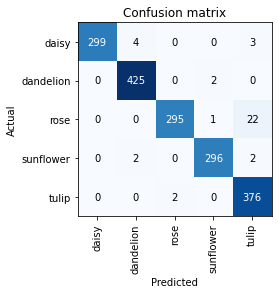

In [25]:
# Now again plotting the confusion matrix 

# Confusion Matrix 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


Not much a change, but we deleted some noisy images which were said to be flowers. 

In [44]:
# Getting the predictions 

clas, clas_idx, probs = learn.predict(fns[88]); 
clas # For one image

'tulip'

In [43]:
# It's tulip indeed

fns[88]

Path('flowers/flowers/tulip/8908097235_c3e746d36e_n.jpg')

In [64]:
vocab_list = list(dls.vocab)
vocab_list

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [67]:
idx = 0
for i in vocab_list:
    print(f'Index of {i}: {idx}')
    idx+=1 
    

Index of daisy: 0
Index of dandelion: 1
Index of rose: 2
Index of sunflower: 3
Index of tulip: 4


In [54]:
# Now let' use our test image in action 

clas, clas_idx, probs = learn.predict('test.jpg'); 

print(f'Class: {clas}')
print(f'Index of the class {clas}: {clas_idx}')
print(f'Probability of its being {clas}: {float(probs[2])}') # index 2 is rose 

Class: rose
Index of the class rose: 2
Probability of its being rose: 0.999940037727356
